<a href="https://colab.research.google.com/github/BenjaminEngel919/Medical-Data/blob/main/Stroke_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Benjamin Engel

##Usual Imports

In [1]:
# Pandas
import pandas as pd
# Numpy
import numpy as np
# MatplotLib
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Classification Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


# Set global scikit-learn configuration 
from sklearn import set_config
# Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

In [2]:
## Import and mount drive from Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Load the data
stroke = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/healthcare-dataset-stroke-data.csv')

In [18]:
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
#Object Columns
stroke_types = stroke.dtypes
str_cols = stroke_types[ stroke_types=='object'].index
str_cols

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [6]:
## Display the number of rows and columns for the dataframe
stroke.shape
print(f'There are {stroke.shape[0]} rows, and {stroke.shape[1]} columns.')

There are 5110 rows, and 12 columns.


In [7]:
# Display the column names, count of non-null values, and their datatypes
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


#Cleaning the Data

In [8]:
# Drop columns
#Column id has nothing to do with Strokes, so we will drop it
stroke = stroke.drop(columns=['id'])

In [9]:
# Display the number of duplicate rows in the dataset
print(f'There are {stroke.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


In [10]:
# Display the total number of missing values
print(f'There are {stroke.isna().sum().sum()} missing values.')

There are 201 missing values.


In [30]:
# Check for missing values for each feature.
stroke.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


- We will need to use SimpleImputer in our preprocessing steps to impute missing values.


In [12]:
# Check for and address any impossible values in numeric columns.
stroke.describe(include='number')

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


- Only outlier I see is bmi of 97.6. But sadly this is very possible for the super obese. So I will leave it be.

In [13]:
# Check for and address any inconsistent values in categorical columns.
stroke.describe(include='object')

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


In [14]:
#Object Type Columns
dtypes = stroke.dtypes
str_cols = dtypes[dtypes=='object'].index
str_cols

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [15]:
for col in str_cols:
    print(f"- Column= {col}")
    print(stroke[col].value_counts(dropna=False))
    print('\n\n')

- Column= gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64



- Column= ever_married
Yes    3353
No     1757
Name: ever_married, dtype: int64



- Column= work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64



- Column= Residence_type
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64



- Column= smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64





Only part of the data I could get rid of would be the 'Other' value in gender. I could delete this row but I would lose the other info in that row. So while  a few of my visuals may look weird it is worth it to keep it so I don't lose the rest of the data in that row.


#Visuals

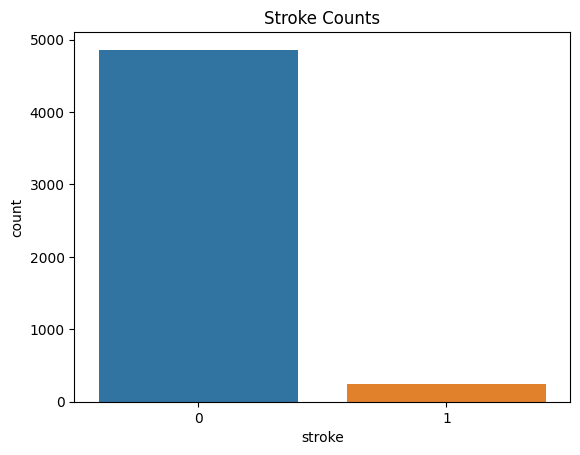

In [20]:
# Check univariate distributions and explore categorical variable(s)
import seaborn as sns
ax = sns.countplot(x=stroke['stroke'])
ax.set_title('Stroke Counts');

Highly Unbalanced data set. In a good way.

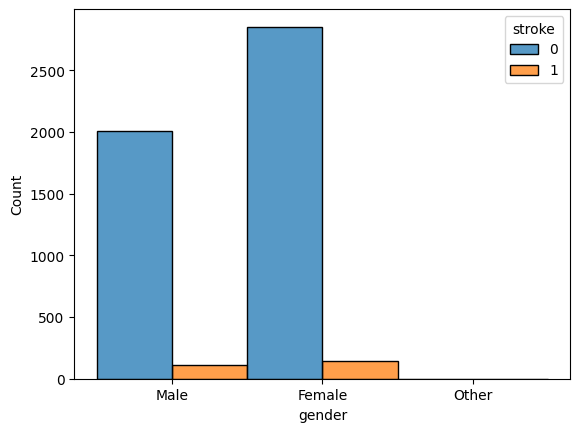

In [21]:
sns.histplot(binwidth=1,
            hue=stroke['stroke'],
            x=stroke['gender'],
            data=stroke,
            stat="count",
            multiple="dodge");

Suprisingly more total strokes in females but higher percentage of males have them.

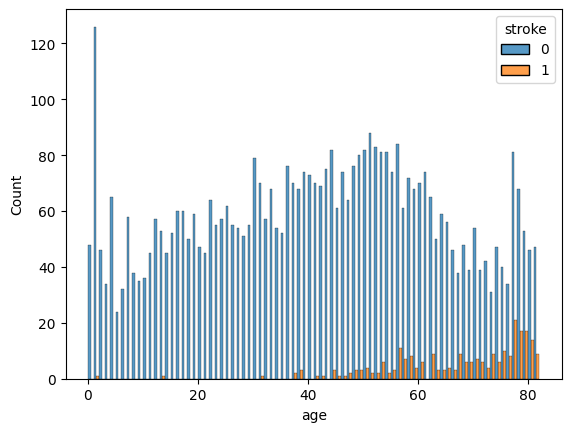

In [25]:
sns.histplot(binwidth=1,
            hue=stroke['stroke'],
            x=stroke['age'],
            data=stroke,
            stat="count",
            multiple="dodge");

This graph shows how rare strokes are in your 30s and 40s and how the occurance increases as you age.

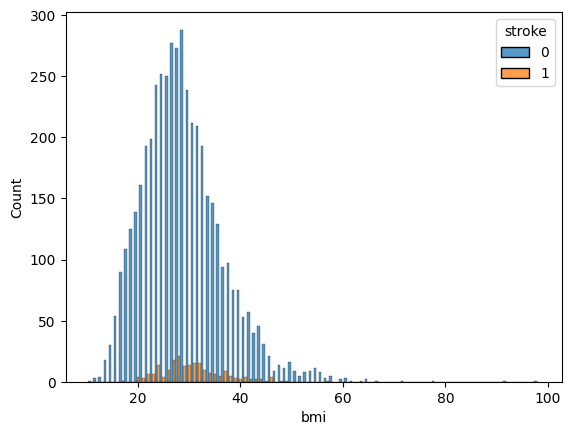

In [26]:
sns.histplot(binwidth=1,
            hue=stroke['stroke'],
            x=stroke['bmi'],
            data=stroke,
            stat="count",
            multiple="dodge");

This graph shows as your bmi gets into the obese catagory your stroke risk goes up greatly.

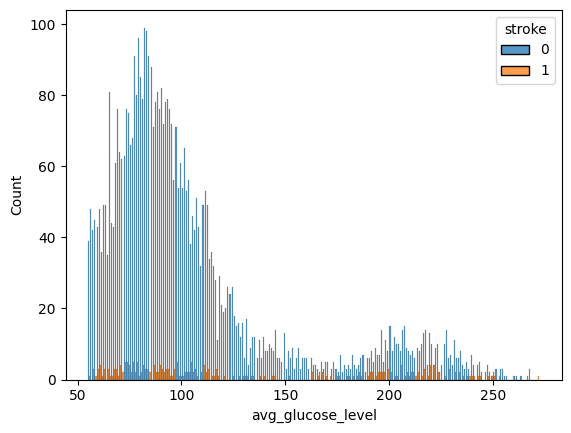

In [28]:
sns.histplot(binwidth=1,
            hue=stroke['stroke'],
            x=stroke['avg_glucose_level'],
            data=stroke,
            stat="count",
            multiple="dodge");

This graph shows that your glucose level doesn't seem to have as much as a corelation to stroke as one might think. People of all glucose levels had strokes based on this graph.

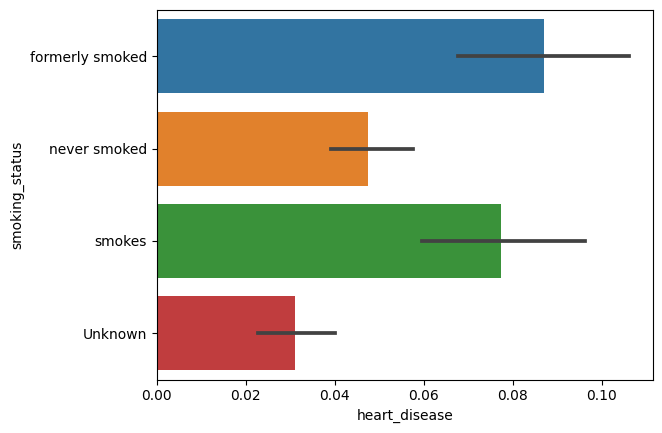

In [29]:
sns.barplot(data=stroke, y='smoking_status', x='heart_disease');

Finally, this graph shows us the dangers of smoking. Formerly smoked or smokes have a much higher risk of heart disease.